# Recovering images with a Unet

The goal of this homework is to implement a simple method that recovers CT images from few measurements using a Unet. Training a Unet is time intensive, therefore we work with a 100 images only. This setup save us computational time relative to working with real-world large datasets arising in practical applications.

Most of the implementation is set up already, and the Unet is already included. Your task is to implement the loss functions and train the network. The loss function could be $||\mathrm{Unet}(A^T(y)) - x||_2^2$. 

In [ ]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/Colab Notebooks/inverse_problem/HW5/'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Unet_problem.ipynb', '__MACOSX', '__pycache__', 'data', 'radon.py', 'unet.py']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import urllib.request
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.fft

from unet import Unet
from radon import get_operators

In [ ]:
data_path = gdrive_path + 'data/'  ####enter your data path here

In [ ]:
device = 'cuda' #'cuda' for GPU, 'cpu' otherwise
img = torch.load(data_path + '0')

### We consider reconstruction from 8x undersampled random measurements

In [ ]:
a = img.shape[-1]
f = 8 #undersampling factor
radon_op, fbp_op = get_operators(n_angles=a//f, image_size=a, circle=True, device=device)

#forward model representing a radon transform
def A(x):
    y = radon_op(x)
    return y

#We use filtered back projection as an estimate of A.T
def AT(y):
    x = fbp_op(y)
    x = x.to(torch.float32)
    return x

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
##Prepare data
class data():
    def __init__(self, path):
        self.path = path

    def __len__(self):
        return len(os.listdir(self.path))
    
    def __getitem__(self, idx):
        data = torch.load(self.path + str(idx)).to(device)
        return data

In [ ]:
data_set = data(data_path)

#Split dataset into 99 imgs for training and 1 img for validation
train_set, val_set = torch.utils.data.random_split(data_set, [99, 1], generator=torch.Generator().manual_seed(0))

#Dataloader
train_dl = DataLoader(train_set, batch_size=1)
val_dl = DataLoader(val_set, batch_size=1)

In [ ]:
model = Unet()
model = model.to(device)

In [ ]:
from torchsummary import summary
print(img.shape)
summary = summary(model, img.shape)

torch.Size([1, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 21, 256, 256]             189
    InstanceNorm2d-2         [-1, 21, 256, 256]               0
         LeakyReLU-3         [-1, 21, 256, 256]               0
         Dropout2d-4         [-1, 21, 256, 256]               0
            Conv2d-5         [-1, 21, 256, 256]           3,969
    InstanceNorm2d-6         [-1, 21, 256, 256]               0
         LeakyReLU-7         [-1, 21, 256, 256]               0
         Dropout2d-8         [-1, 21, 256, 256]               0
         ConvBlock-9         [-1, 21, 256, 256]               0
           Conv2d-10         [-1, 42, 128, 128]           7,938
   InstanceNorm2d-11         [-1, 42, 128, 128]               0
        LeakyReLU-12         [-1, 42, 128, 128]               0
        Dropout2d-13         [-1, 42, 128, 128]               0
           Co

### Implement the loss functions and train your network here. You don't have to train the network for many epochs. Around 10 epochs should be enough to reach a good solution.

In [ ]:
def mse(x_unet, x):
    return torch.linalg.norm(x_unet - x) ** 2 / np.prod(x.shape)

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 train_dl: torch.utils.data.DataLoader,
                 epochs: int = 10):
        self.model = model
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dl = train_dl
        self.epochs = epochs

        self.training_loss = []

    def run_trainer(self):
        for i in tqdm(range(self.epochs)):
            mse = self.training()
            self.training_loss.append(mse)
            print('Epoch: %d\t Training loss: %.5f' % (i + 1, mse))

        return self.training_loss

    def training(self):
        self.model.train()  # train mode
        train_losses = []   # accumulate the losses here

        for _ in range(len(self.train_dl)):
            x = next(iter(self.train_dl))
            y = A(x)

            x = x.to(self.device)   # send to device (GPU or CPU)
            y = y.to(self.device)

            # Unet training
            self.optimizer.zero_grad()  # zerograd the parameters
            x_unet = self.model(AT(y))  # one forward pass
            loss = self.criterion(x_unet, x)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

        return np.mean(train_losses)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer(model=model,
                  device=torch.device(device),
                  criterion=criterion,
                  optimizer=optimizer,
                  train_dl=train_dl,
                  epochs=30)

training_loss = trainer.run_trainer()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1	 Training loss: 0.04643
Epoch: 2	 Training loss: 0.00807
Epoch: 3	 Training loss: 0.00518
Epoch: 4	 Training loss: 0.00392
Epoch: 5	 Training loss: 0.00320
Epoch: 6	 Training loss: 0.00273
Epoch: 7	 Training loss: 0.00239
Epoch: 8	 Training loss: 0.00214
Epoch: 9	 Training loss: 0.00195
Epoch: 10	 Training loss: 0.00179
Epoch: 11	 Training loss: 0.00167
Epoch: 12	 Training loss: 0.00156
Epoch: 13	 Training loss: 0.00147
Epoch: 14	 Training loss: 0.00139
Epoch: 15	 Training loss: 0.00133
Epoch: 16	 Training loss: 0.00127
Epoch: 17	 Training loss: 0.00121
Epoch: 18	 Training loss: 0.00116
Epoch: 19	 Training loss: 0.00112
Epoch: 20	 Training loss: 0.00108
Epoch: 21	 Training loss: 0.00105
Epoch: 22	 Training loss: 0.00102
Epoch: 23	 Training loss: 0.00099
Epoch: 24	 Training loss: 0.00096
Epoch: 25	 Training loss: 0.00093
Epoch: 26	 Training loss: 0.00091
Epoch: 27	 Training loss: 0.00089
Epoch: 28	 Training loss: 0.00087
Epoch: 29	 Training loss: 0.00085
Epoch: 30	 Training los

### Visualization how Unet reconstructs an image

In [ ]:
sample = next(iter(val_dl))  #img from val set
y = A(sample)

x_unet = model(AT(y))     ###enter your Unet's reconstruction here 
# print(sample.shape)

val_loss = mse(x_unet, sample)
print('val_loss:', val_loss.item())

val_loss: 0.0009964547352865338


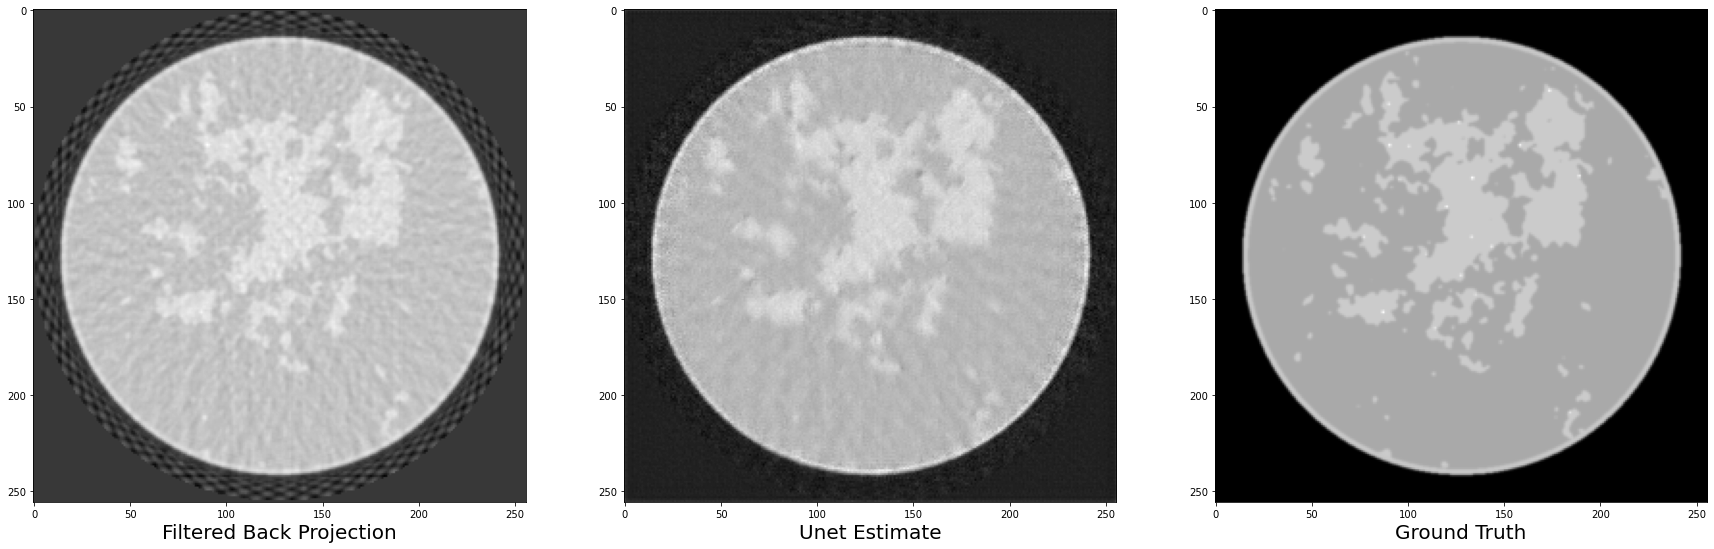

In [ ]:
x_unet = x_unet.detach().cpu().squeeze(0).squeeze(0)
x_fbp = AT(y).cpu().squeeze(0).squeeze(0)
x = sample.cpu().squeeze(0).squeeze(0)

fig = plt.figure(figsize=(30, 30))

#Coarse Estimate (A.T@y + Filter)
fig.add_subplot(1, 3, 1)
plt.imshow(x_fbp, cmap='gray')
plt.xlabel('Filtered Back Projection', fontsize=20)

#Unet estimate
fig.add_subplot(1, 3, 2)
plt.imshow(x_unet, cmap='gray')
plt.xlabel('Unet Estimate', fontsize=20)

#Ground Truth
fig.add_subplot(1, 3, 3)
plt.imshow(x, cmap='gray')
plt.xlabel('Ground Truth', fontsize=20)

plt.show()